# Canny Edge Detection

This is a demo of [Canny edge detection](https://en.wikipedia.org/wiki/Canny_edge_detector) using [OpenCV](https://opencv.org/).

## Step 1: Noise Reduction

The first step is to apply a Gaussian filter to smooth the image in order to remove the noise. The resulting image is less sensitive to noise and more suitable for edge detection.

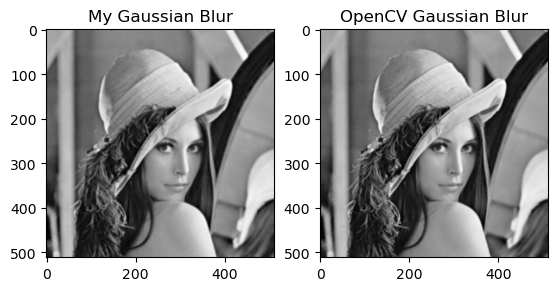

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import convolve2d

# Read the image
img = cv2.imread("images/lena.png", 0)


def gaussian_blur(img):
    # Use Gaussian Blur to remove noise
    # 5x5 kernel
    gauss_mask = (
        np.array(
            [
                [2, 4, 5, 4, 2],
                [4, 9, 12, 9, 4],
                [5, 12, 15, 12, 5],
                [4, 9, 12, 9, 4],
                [2, 4, 5, 4, 2],
            ]
        )
        / 159
    )

    # Since the kernel is 2 more than the image, we pad the image with 2 using reflection
    padded = np.pad(img, 2, mode="reflect")

    # Starting from the first non-padded pixel, we convolve the kernel with the image
    # and store the result in the output image
    out = convolve2d(padded, gauss_mask, mode="valid")

    # Convert the output image to uint8
    return out.astype(np.uint8)


my_blur = gaussian_blur(img)
opencv_blur = cv2.GaussianBlur(img, (5, 5), 1)

# Plot the images
plt.figure(figsize=(10, 10))

plt.subplot(131)
plt.imshow(my_blur, cmap="gray")
plt.title("My Gaussian Blur")

plt.subplot(132)
plt.imshow(opencv_blur, cmap="gray")
plt.title("OpenCV Gaussian Blur")

plt.show()


## Step 2: Finding Intensity Gradient of the Image

The second step is to find the intensity gradient of the image. The image is convolved with a filter (e.g., Sobel) in both the horizontal and vertical directions. From this, we can find the edge gradient and direction for each pixel as follows:

$$
\begin{align}
G &= \sqrt{G_x^2 + G_y^2} \\
\theta &= \arctan{\frac{G_y}{G_x}}
\end{align}
$$

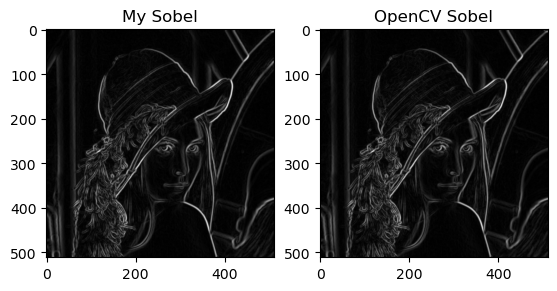

In [2]:
def sobel(image):
    # Sobel operator in x direction
    sobel_x = [
        [1, 0, -1],
        [2, 0, -2],
        [1, 0, -1],
    ]
    sobel_x = np.array(sobel_x, dtype=np.float64)

    # Sobel operator in y direction
    sobel_y = [
        [1, 2, 1],
        [0, 0, 0],
        [-1, -2, -1],
    ]
    sobel_y = np.array(sobel_y, dtype=np.float64)

    # Pad the image with 1
    padded = np.pad(image, 1, mode="reflect")

    # Convolve the image with the sobel operators using 64-bit floats

    dx = convolve2d(padded, sobel_x, mode="valid")
    dy = convolve2d(padded, sobel_y, mode="valid")

    # Compute the magnitude of the gradient
    gradient_magnitude = np.sqrt(dx**2 + dy**2)

    # Normalize the gradient magnitude
    # gradient_magnitude = np.uint8(gradient_magnitude * 255 / np.max(gradient_magnitude))

    # Compute the direction of the gradient
    gradient_direction = np.arctan2(dy, dx)

    return gradient_magnitude, gradient_direction


def sobel_opencv(image):
    # Compute the gradient in x direction
    dx = cv2.Sobel(image, cv2.CV_64F, 1, 0, ksize=3)

    # Compute the gradient in y direction
    dy = cv2.Sobel(image, cv2.CV_64F, 0, 1, ksize=3)

    # Compute the magnitude of the gradient
    gradient_magnitude = np.sqrt(dx**2 + dy**2)

    # Normalize the gradient magnitude
    # gradient_magnitude = np.uint8(gradient_magnitude * 255 / np.max(gradient_magnitude))

    # Compute the direction of the gradient
    gradient_direction = np.arctan2(dy, dx)

    return gradient_magnitude, gradient_direction


my_sobel, my_direction = sobel(opencv_blur)
opencv_sobel, opencv_direction = sobel_opencv(opencv_blur)


# Plot the images
plt.figure(figsize=(10, 10))

plt.subplot(131)
plt.imshow(my_sobel, cmap="gray")
plt.title("My Sobel")

plt.subplot(132)
plt.imshow(opencv_sobel, cmap="gray")
plt.title("OpenCV Sobel")

plt.show()


## Step 3: Non-maximum Suppression

After getting the gradient magnitude and direction, a full scan of the image is done to remove any unwanted pixels which may not constitute the edge. For this, we check every pixel to see if it is a local maximum in its neighborhood in the direction of the gradient.

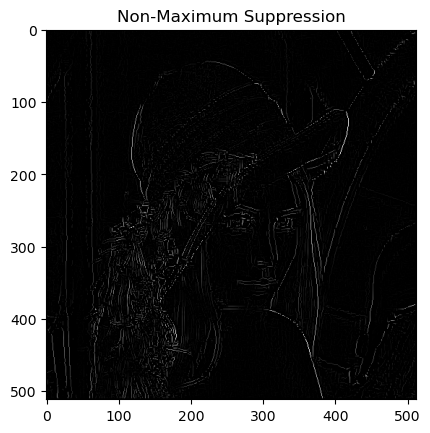

In [3]:
def non_max_suppresion(m, d):
    # Round the gradient direction to 0, 45, 90, or 135 degrees
    deg = np.rad2deg(d)
    deg[deg < 0] += 180
    deg = np.round(deg / 45) * 45

    # Get the dimensions of the image, height and width
    h, w = m.shape

    # Create a new image of zeros with the same shape as the original image
    new_image = np.zeros((h, w))

    # Iterate over the image pixels
    for i in range(1, h - 1):
        for j in range(1, w - 1):
            # Get the current gradient direction
            direction = deg[i, j]

            # Check if the current pixel is a maximum
            if direction == 0 or direction == 180:
                is_max = m[i, j] >= m[i, j - 1] and m[i, j] >= m[i, j + 1]
            elif direction == 45:
                is_max = m[i, j] >= m[i - 1, j + 1] and m[i, j] >= m[i + 1, j - 1]
            elif direction == 90:
                is_max = m[i, j] >= m[i - 1, j] and m[i, j] >= m[i + 1, j]
            elif direction == 135:
                is_max = m[i, j] >= m[i - 1, j - 1] and m[i, j] >= m[i + 1, j + 1]

            # Set the pixel to 0 if it is not a maximum
            new_image[i, j] = m[i, j] * is_max

    return new_image


# Perform NMS on the image
my_nms = non_max_suppresion(opencv_sobel, opencv_direction)


# Plot the results
plt.imshow(my_nms, cmap="gray")
plt.title("Non-Maximum Suppression")

plt.show()


## Step 4: Hysteresis Thresholding

This stage decides which edges are really edges and which are not. For this, we need two threshold values, `minVal` and `maxVal`. Any edges with intensity gradient more than `maxVal` are sure to be edges and those below `minVal` are sure to be non-edges, so discarded. Those who lie between these two thresholds are classified edges or non-edges based on their connectivity. If they are connected to "sure-edge" pixels, they are considered to be part of edges. Otherwise, they are also discarded.

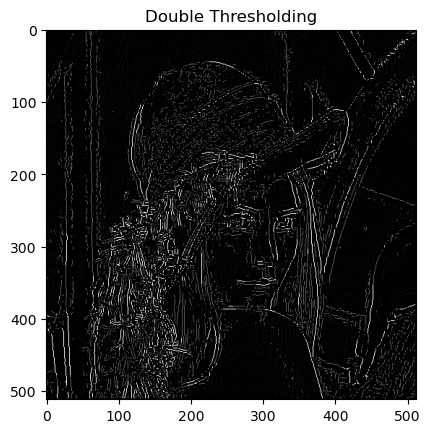

In [4]:
def double_threshold(m, low_threshold, high_threshold):
    # Create a copy of the image
    out = m.copy()

    strong_edges = np.zeros_like(m)
    weak_edges = np.zeros_like(m)

    # Get the strong edges
    strong_edges[m >= high_threshold] = 1

    # Get the weak edges
    weak_edges[np.logical_and(m >= low_threshold, m < high_threshold)] = 1

    out[strong_edges == 1] = 255
    out[weak_edges == 1] = 100
    
    return out, strong_edges, weak_edges


# Perform double thresholding
my_dh, strong, weak = double_threshold(my_nms, 20, 100)

# Plot the results
plt.imshow(my_dh, cmap="gray")
plt.title("Double Thresholding")

plt.show()



## Step 5: Edge Tracking by Hysteresis

A pixel is considered to belong to an edge if it is connected to a pixel that is already part of an edge.

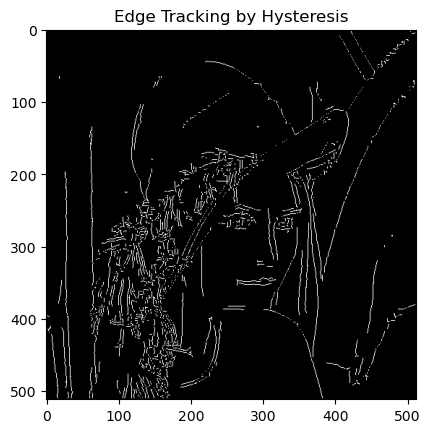

In [5]:
def hysteresis(weak, strong):
    while True:
        indices = np.argwhere(weak > 0)
        found = False
        # Iterate over the weak edges
        for i, j in indices:
            neighborhood = strong[i - 1 : i + 2, j - 1 : j + 2]
            if np.any(neighborhood > 0):
                found = True
                weak[i, j] = 0
                strong[i, j] = 1

        # If there are no new strong edges, we are done
        if not found:
            break

    strong[strong > 0] = 255

    return strong


# Perform edge tracking by hysteresis
my_edge = hysteresis(weak, strong)

# Plot the results
plt.imshow(my_edge, cmap="gray")
plt.title("Edge Tracking by Hysteresis")

plt.show()


In [6]:
def my_canny(image, low_threshold, high_threshold):
    # Perform Gaussian Blur
    blur = gaussian_blur(image)

    # Perform Sobel Edge Detection
    gradient_magnitude, gradient_direction = sobel(blur)

    # Perform Non-Maximum Suppression
    nms = non_max_suppresion(gradient_magnitude, gradient_direction)

    # Perform Double Thresholding
    dh, strong, weak = double_threshold(nms, low_threshold, high_threshold)

    # Perform Edge Tracking by Hysteresis
    edge = hysteresis(weak, strong)

    # Return a single channel image (uint8)
    return edge


sample = cv2.imread("images/engine.png", 0)

from ipywidgets import interact, IntSlider

# low should be half of high


@interact(
    low=IntSlider(min=0, max=255, step=1, value=50),
    high=IntSlider(min=0, max=255, step=1, value=100),
)
def my_canny_interactive(low, high):
    # Perform Canny Edge Detection using the custom function
    my_canny_result = my_canny(sample, low, high)

    # Perform Canny Edge Detection using OpenCV
    opencv_canny_result = cv2.Canny(sample, 100, 200)

    # Save the results

    cv2.imwrite("images/canny.png", my_canny_result)
    cv2.imwrite("images/canny_opencv.png", opencv_canny_result)

    # Plot the images
    plt.figure(figsize=(16, 16))

    plt.subplot(131)
    plt.imshow(sample, cmap="gray")
    plt.title("Original")

    plt.subplot(132)
    plt.imshow(my_canny_result, cmap="gray")
    plt.title("Custom Canny")

    plt.subplot(133)
    plt.imshow(opencv_canny_result, cmap="gray")
    plt.title("OpenCV Canny")

    plt.show()


interactive(children=(IntSlider(value=50, description='low', max=255), IntSlider(value=100, description='high'…